In [1]:
import os
os.environ['SPOTIPY_CLIENT_ID'] = '0dd677ab735f4fd1b9dbf6b236350ba1'
os.environ['SPOTIPY_CLIENT_SECRET'] = 'bbe8736a14ba4e64bfb2d4103c8957aa'
os.environ['SPOTIPY_REDIRECT_URI'] = 'http://google.com/'

In [2]:
import sys
sys.path.append('../OOSpotify/')
from OOSpotify import *
import pickle

We need to get big labeled lists of songs grouped by genres in order to build a genre-predicting neural network. There are a number of ways to compile these lists, but it would be awesome if we could do it all within Spotify with a few simply OOSpotify calls.

Fortunately for us, Glenn McDonald, the official 'Data Alchemist' at Spotify, has made that possible with his 'Every Noise At Once' project http://everynoise.com/everynoise1d.cgi?scope=all. There are almost 2000 individual genres here (with mixing, but that's ok), and Glenn's made them all into long playlists in Spotify under the username 'thesoundsofspotify'. 

Let's use the User object to check them out!

This takes a while because there are a ton of playlists ...

In [3]:
sos = User('thesoundsofspotify')
allplaylists = sos.getPlaylists()

All SpotifyObj objects have a Attributes() method, which lets us know what information we have to work with:

In [4]:
allplaylists[0].Attributes()

type
collaborative
external_urls
href
id
images
name
owner
primary_color
public
snapshot_id
tracks
uri
ownerid


If you want to look at the full list of Playlists, run the following cell:

In [5]:
for i in allplaylists:
    print(i.name)

The Needle
The Needle - Current
The Needle - Emerging
The Needle - Underground
The Needle / Andorra
The Needle / Andorra - Current
The Needle / Argentina
The Needle / Argentina - Current
The Needle / Argentina - Emerging
The Needle / Argentina - Underground
The Needle / Australia
The Needle / Australia - Current
The Needle / Australia - Emerging
The Needle / Australia - Underground
The Needle / Austria
The Needle / Austria - Current
The Needle / Austria - Emerging
The Needle / Austria - Underground
The Needle / Belgium
The Needle / Belgium - Current
The Needle / Belgium - Emerging
The Needle / Belgium - Underground
The Needle / Bolivia
The Needle / Bolivia - Current
The Needle / Bolivia - Emerging
The Needle / Brazil
The Needle / Brazil - Current
The Needle / Brazil - Emerging
The Needle / Brazil - Underground
The Needle / Bulgaria
The Needle / Bulgaria - Current
The Needle / Bulgaria - Emerging
The Needle / Canada
The Needle / Canada - Current
The Needle / Canada - Emerging
The Needle

The Sound of St Albans GB
The Sound of St Helens GB
The Sound of St Petersburg RU
The Sound of St Kilda AU
The Sound of St Louis Missouri US
The Sound of St. Catharines CA
The Sound of St. Gallen CH
The Sound of Stadskanaal NL
The Sound of St. Petersburg Florida US
The Sound of Stabekk NO
The Sound of Spijkenisse NL
The Sound of Spokane Washington US
The Sound of Staines GB
The Sound of Spring Texas US
The Sound of Stafford GB
The Sound of Springfield Missouri US
The Sound of Stamford Connecticut US
The Sound of Stanmore AU
The Sound of Stanmore GB
The Sound of Spånga SE
The Sound of Staten Island New York US
The Sound of Steenwijk NL
The Sound of Steenbergen NL
The Sound of Stade DE
The Sound of Steinheim am der Murr DE
The Sound of Staffanstorp SE
The Sound of Stains FR
The Sound of Stepney AU
The Sound of Turdera AR
The Sound of Stillwater Oklahoma US
The Sound of State College Pennsylvania US
The Sound of Stavanger NO
The Sound of Steinkjer NO
The Sound of Stenungsund SE
The Sound 

This list of playlists is ridiculously awesome and their creation and meaning can be explored infinitely on (everynoise.com) and Glenn's blog, (furia.com). For now, we're just going to grab some more well-known genre playlists. The ones we want all begin with 'The Sound of' and then a genre. 

In [5]:
tso = 'the sound of '
genre_list = ['rock','pop','alternative rock','electronic','jazz','classical',
              'folk','indie rock','blues','soundtrack','bluegrass','gospel',
              'country','grunge','ska punk','metal','reggae','rap','punk rock',
              'dubstep','motown','edm','emo','hip hop']
simple_genres = [tso+i for i in genre_list]

genre_playlists = [i for i in allplaylists if i.name.lower() in simple_genres]
print('Number of Genres:',len(genre_playlists))

# Save the list to a pickle file to save time in the future in case the notebook gets shut down for some reason
pickle.dump(genre_playlists,open('genre_playlists.p','wb'))

Number of Genres: 23


There wasn't any rhyme or reason to those genre choices, but they seem like a reasonable grouping. Our genre_playlists list now contains Playlist objects for 23 genres. We'll use the getTracks() method to create Track objects for every track in every playlist. Again, this will take a long time because it's making thousands of calls to the Spotify Web API.

In [6]:
genre_tracks = [i.getTracks() for i in genre_playlists]

# Save the list to a pickle file to save time in the future in case the notebook gets shut down for some reason
pickle.dump(genre_tracks,open('genre_tracks.p','wb'))

Let's see what we're working with ...

In [13]:
[('Length: {}, Genre: {}'.format(len(i),j.name)) for i,j in zip(genre_tracks,genre_playlists)]

['Length: 707, Genre: The Sound of Alternative Rock',
 'Length: 355, Genre: The Sound of Bluegrass',
 'Length: 429, Genre: The Sound of Blues',
 'Length: 477, Genre: The Sound of Classical',
 'Length: 526, Genre: The Sound of Country',
 'Length: 295, Genre: The Sound of Dubstep',
 'Length: 800, Genre: The Sound of EDM',
 'Length: 500, Genre: The Sound of Electronic',
 'Length: 649, Genre: The Sound of Emo',
 'Length: 617, Genre: The Sound of Folk',
 'Length: 343, Genre: The Sound of Gospel',
 'Length: 219, Genre: The Sound of Grunge',
 'Length: 1005, Genre: The Sound of Hip Hop',
 'Length: 830, Genre: The Sound of Indie Rock',
 'Length: 399, Genre: The Sound of Jazz',
 'Length: 608, Genre: The Sound of Metal',
 'Length: 472, Genre: The Sound of Motown',
 'Length: 1128, Genre: The Sound of Pop',
 'Length: 843, Genre: The Sound of Rap',
 'Length: 399, Genre: The Sound of Reggae',
 'Length: 953, Genre: The Sound of Rock',
 'Length: 344, Genre: The Sound of Ska Punk',
 'Length: 411, Genre:

Our genre sizes are a bit unbalanced, but we'll leave them as is for now. The next step is grabbing the relevant features that will enable genre prediction. The OOSpotify_Examples notebook in the OOSpotify folder gave us insight into what data we can get from the Spotify API for each track. We already have access to the Echo Nest Audio Features for each track:

In [14]:
genre_tracks[0][0].features

{'acousticness': 0.0189,
 'danceability': 0.523,
 'energy': 0.442,
 'instrumentalness': 0.000494,
 'key': 4,
 'liveness': 0.0784,
 'loudness': -14.121,
 'mode': 1,
 'speechiness': 0.0347,
 'tempo': 81.083,
 'time_signature': 4,
 'valence': 0.277}

The other thing we want is the Audio Analysis, which is time-series data containing valuable info about the timbre, pitch, and loudness throughout each song. We'll use the getAudioAnalysis() method built into our Track objects to grab this. This call will take even longer, so we'll pickle every genre individually and print out a completion message each time we finish a genre.

In [15]:
#genre_audio_analysis = [[x.getAudioAnalysis() for x in genre] for genre in genre_tracks]
#list comprehension is cool, but it might be better not to use it in this case in order to get an idea 
#of the progress you're making because it'll take forevvvvver

genre_audio_analysis = []
for i,genre in enumerate(genre_tracks):
    single_genre = []
    for track in genre:
        single_genre.append(track.getAudioAnalysis())
    pickle.dump(single_genre,open('AA_{}.p'.format(genre_playlists[i].name),'wb'))        
    genre_audio_analysis.append(single_genre)
    print('Completed {}'.format(genre_playlists[i].name))

Completed The Sound of Alternative Rock
Completed The Sound of Bluegrass
Completed The Sound of Blues
Completed The Sound of Classical
Completed The Sound of Country
Completed The Sound of Dubstep
Completed The Sound of EDM
Completed The Sound of Electronic
Completed The Sound of Emo
Completed The Sound of Folk
Completed The Sound of Gospel
Completed The Sound of Grunge
Completed The Sound of Hip Hop
Completed The Sound of Indie Rock
Completed The Sound of Jazz
Completed The Sound of Metal
Completed The Sound of Motown
Completed The Sound of Pop
Completed The Sound of Rap
Completed The Sound of Reggae
Completed The Sound of Rock
Completed The Sound of Ska Punk
Completed The Sound of Soundtrack


That was a lot. One more dump for good measure.

In [16]:
pickle.dump(genre_audio_analysis,open('genre_audio_analysis.p','wb'))

Here's the code for the reload in case you need it :-)

In [ ]:
genre_playlists = pickle.load(open('genre_playlists.p','rb'))
genre_tracks = pickle.load(open('genre_tracks.p','rb'))

genre_audio_analysis = []
for i in range(len(genre_playlists)):
    genre_audio_analysis.append(pickle.load(open(genre_playlists[i].name+'.p','rb')))
    print('loaded',genre_playlists[i].name)
    
#or
#genre_audio_analysis = pickle.load(open('genre_audio_analysis.p','rb'))

Just making sure everything is in order ...

In [22]:
for genre,playlist,tracks in zip(genre_audio_analysis,genre_playlists,genre_tracks):
    print(playlist.name,len(genre),len(tracks))

The Sound of Alternative Rock 707 707
The Sound of Bluegrass 355 355
The Sound of Blues 429 429
The Sound of Classical 477 477
The Sound of Country 526 526
The Sound of Dubstep 295 295
The Sound of EDM 800 800
The Sound of Electronic 500 500
The Sound of Emo 649 649
The Sound of Folk 617 617
The Sound of Gospel 343 343
The Sound of Grunge 219 219
The Sound of Hip Hop 1005 1005
The Sound of Indie Rock 830 830
The Sound of Jazz 399 399
The Sound of Metal 608 608
The Sound of Motown 472 472
The Sound of Pop 1128 1128
The Sound of Rap 843 843
The Sound of Reggae 399 399
The Sound of Rock 953 953
The Sound of Ska Punk 344 344
The Sound of Soundtrack 411 411


The next two cells are just verifying that the pickle file has preserved the object funcionality for the SpotifyObjs we made earlier.

In [23]:
a = pickle.load(open('genre_playlists.p','rb'))
a[0].tracks

{'href': 'https://api.spotify.com/v1/users/thesoundsofspotify/playlists/3dlw4x21qVajwZLPNHtS3u/tracks',
 'total': 707}

In [24]:
b = pickle.load(open('genre_tracks.p','rb'))
b[0][0].Attributes()

type
album
artists
available_markets
disc_number
duration_ms
episode
explicit
external_ids
external_urls
href
id
is_local
name
popularity
preview_url
track
track_number
uri
features


And now let's just put everything in one place to use for some deep learning (link)! I promise this won't take nearly as long as the earlier stuff. And it'll be worth it later.

In [25]:
import pandas as pd
genreDict = {}
for i,playlist in enumerate(genre_playlists):
    gname = ' '.join(playlist.name.split()[3:])
    genreDict[gname] = {}
    genreDict[gname]['id'] = i
    genreDict[gname]['playlistName'] = playlist.name
    genreDict[gname]['playlistObject'] = playlist
    genreDict[gname]['trackList'] = []
    genreDict[gname]['trackDict'] = []
    for track,aud in zip(genre_tracks[i],genre_audio_analysis[i]):
        genreDict[gname]['trackList'].append((track.name,track.artists[0]['name']))
        genreDict[gname]['trackDict'].append({'name':track.name,
                                              'artist':track.artists[0]['name'],
                                              'trackObj':track,
                                              'trackAA':aud,
                                              'trackSegs':pd.DataFrame(aud['segments'])})
                                     
    
    

In [ ]:
pickle.dump(genreDict,open('genreDict.p','wb'))

Here's a quick glimpse into what we now have at our fingertips to use!

Alternative Rock: Where Is My Mind? - Pixies
{'danceability': 0.523, 'energy': 0.442, 'key': 4, 'loudness': -14.121, 'mode': 1, 'speechiness': 0.0347, 'acousticness': 0.0189, 'instrumentalness': 0.000494, 'liveness': 0.0784, 'valence': 0.277, 'tempo': 81.083, 'time_signature': 4}
Bluegrass: It's All Over Now, Baby Blue - The Seldom Scene
{'danceability': 0.414, 'energy': 0.23, 'key': 0, 'loudness': -11.566, 'mode': 1, 'speechiness': 0.0301, 'acousticness': 0.912, 'instrumentalness': 0.024, 'liveness': 0.103, 'valence': 0.463, 'tempo': 153.74, 'time_signature': 4}
Blues: Working Man - Otis Rush
{'danceability': 0.633, 'energy': 0.625, 'key': 0, 'loudness': -10.951, 'mode': 1, 'speechiness': 0.0436, 'acousticness': 0.492, 'instrumentalness': 0.000418, 'liveness': 0.204, 'valence': 0.841, 'tempo': 103.355, 'time_signature': 4}
Classical: Sonata No. 14 "Moonlight" in C-Sharp Minor", Op. 27 No. 2: I. Adagio sostenuto - Ludwig van Beethoven
{'danceability': 0.184, 'energy': 0.00527, 'key': 1

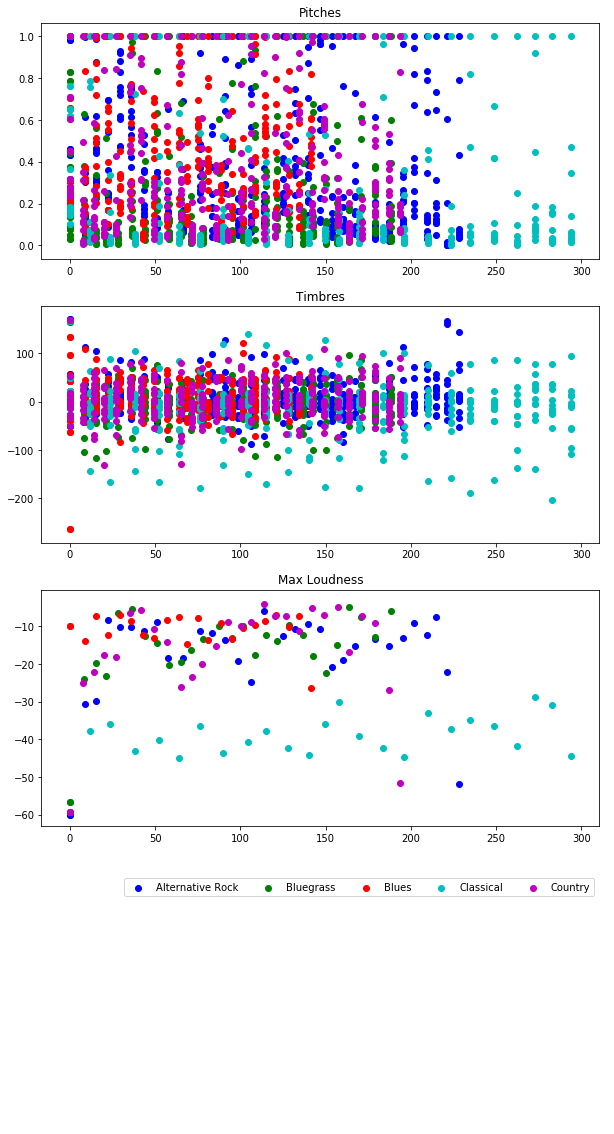

In [30]:
import matplotlib.pyplot as plt
c = ['b','g','r','c','m','y','k']
f,ax = plt.subplots(4,1,figsize=(10,20))
for key in list(genreDict.keys())[:5]:
    s1=genreDict[key]['trackDict'][0]
    segs = s1['trackSegs']
    print('{}: {} - {}'.format(key,s1['name'],s1['artist']))
    print(s1['trackObj'].features)
    for i,data in enumerate(zip(segs.start,segs.pitches,segs.timbre,segs.loudness_max)):
        start,pitches,timbre,mloudness = data
        if i==0:
            ax[0].scatter([start]*len(pitches),pitches,c=c[genreDict[key]['id']%len(c)],label=key)
            ax[0].set_title('Pitches')
            ax[1].scatter([start]*len(timbre),timbre,c=c[genreDict[key]['id']%len(c)],label=key)
            ax[1].set_title('Timbres')
            ax[2].scatter(start,mloudness,c=c[genreDict[key]['id']%len(c)],label=key)
            ax[2].set_title('Max Loudness')
            handles,labels = ax[1].get_legend_handles_labels()
        if i%25 == 0:
            ax[0].scatter([start]*len(pitches),pitches,c=c[genreDict[key]['id']%len(c)])
            ax[1].scatter([start]*len(timbre),timbre,c=c[genreDict[key]['id']%len(c)])
            ax[2].scatter(start,mloudness,c=c[genreDict[key]['id']%len(c)])

ax[3].set_axis_off()
ax[3].legend(handles,labels,ncol=5)
plt.show()

In [31]:
genreDict['Blues']['trackDict'][0]['trackSegs'].head()

,confidence,duration,loudness_end,loudness_max,loudness_max_time,loudness_start,pitches,start,timbre
0,1.000,0.85941,NaN,-9.821,0.29454,-60.000,"[0.302, 0.279, 0.225, 0.182, 0.211, 0.199, 0.2...",0.00000,"[11.894, 133.546, 95.955, -262.663, 54.825, 22..."
1,1.000,0.59193,NaN,-9.478,0.06660,-41.859,"[0.182, 0.516, 0.175, 0.345, 0.993, 0.152, 0.1...",0.85941,"[47.527, 124.209, -17.16, -35.664, 29.269, 9.0..."
2,0.799,1.24762,NaN,-5.276,0.05953,-14.388,"[0.282, 0.427, 0.29, 0.207, 0.565, 0.378, 0.39...",1.45134,"[49.74, 76.049, 78.619, 49.475, 21.74, 8.802, ..."
3,1.000,0.29615,NaN,-9.800,0.02391,-24.345,"[0.164, 0.259, 0.201, 0.295, 0.693, 0.213, 0.2...",2.69896,"[42.475, 39.033, -28.965, 109.45, 11.305, -12...."
4,1.000,0.55125,NaN,-7.687,0.05757,-31.555,"[1.0, 0.062, 0.065, 0.05, 0.281, 0.06, 0.071, ...",2.99510,"[47.901, 89.401, 1.427, -11.234, 19.423, 19.04..."
